In [1]:
# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import SIRT
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation \

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL display function
from cil.utilities.display import show2D

# Import from CIL ASTRA plugin
from cil.plugins.tigre import ProjectionOperator

# Import FBP from CIL recon class
from cil.recon import FBP

from cil.framework import ImageData

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Load the example data set
from cil.utilities.dataexample import SYNCHROTRON_PARALLEL_BEAM_DATA
data_sync = SYNCHROTRON_PARALLEL_BEAM_DATA.get()

# Preprocessing
scale = data_sync.get_slice(vertical=20).mean()
data_sync = data_sync/scale
data_sync = TransmissionAbsorptionConverter()(data_sync)
data_sync = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data_sync)

# Crop data and reorder for ASTRA backend
data90 = Slicer(roi={'angle':(0,90), 
                     'horizontal':(20,140,1)})(data_sync)
data90.reorder(order='tigre')

# Set up and run FBP for 90-angle dataset
recon90 = FBP(data90, backend='tigre').run(verbose=0)

# Set up and run FBP for 15-angle dataset
data15 = Slicer(roi={'angle': (0,90,6)})(data90)
recon15 = FBP(data15, backend='tigre').run(verbose=0)

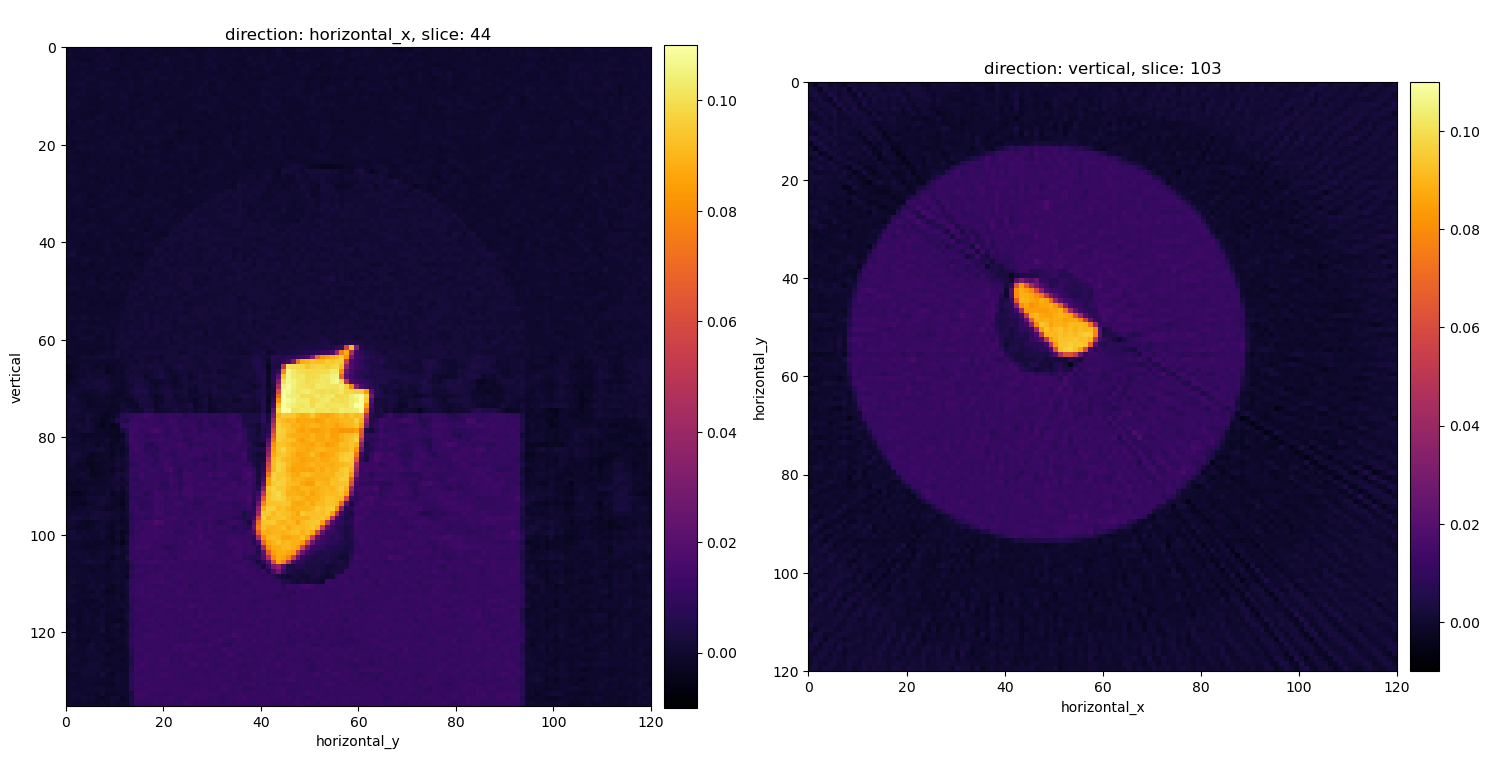

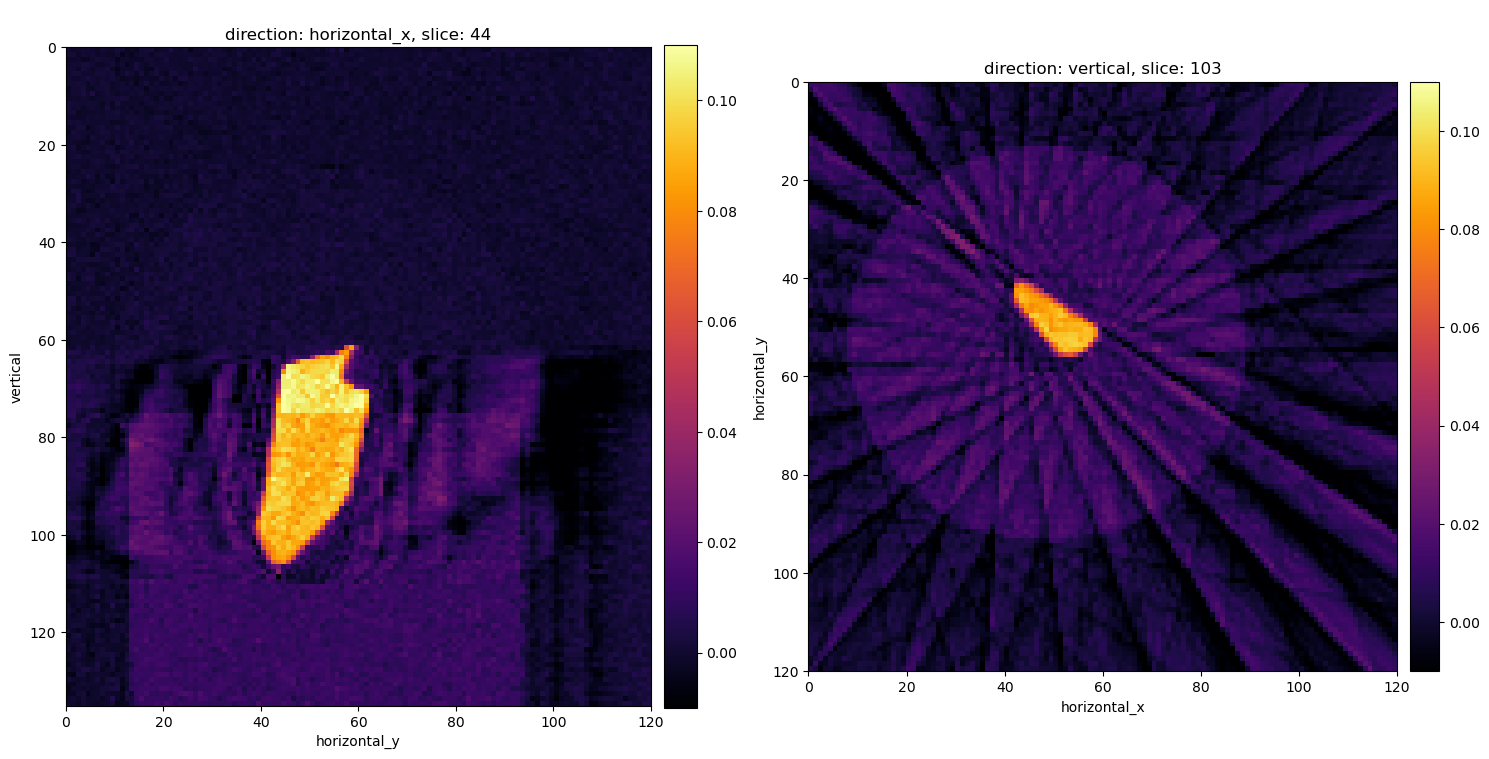

In [3]:
# Define custom parameters for show2D for visualizing all reconstructions consistently
sx = 44
sz = 103
ca1 = -0.01
ca2 =  0.11
slices = [('horizontal_x',sx),('vertical',sz)]

show2D(recon90, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
show2D(recon15, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


# CIL - SIRT algorithm 

In [4]:

ag = data15.geometry
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag, device="gpu")

b = data15

<>:8: SyntaxWarning: invalid escape sequence '\|'
<>:8: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_972608/93328916.py:8: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|Ax-b\|_2^2$')
/home/bih17925/miniconda3/envs/margaret_dev/lib/python3.12/site-packages/cil/framework/data_container.py:412: RuntimeWarning: divide by zero encountered in power
  out = pwop(self.as_array() , x2 , *args, **kwargs )


  0%|          | 0/50 [00:00<?, ?it/s]

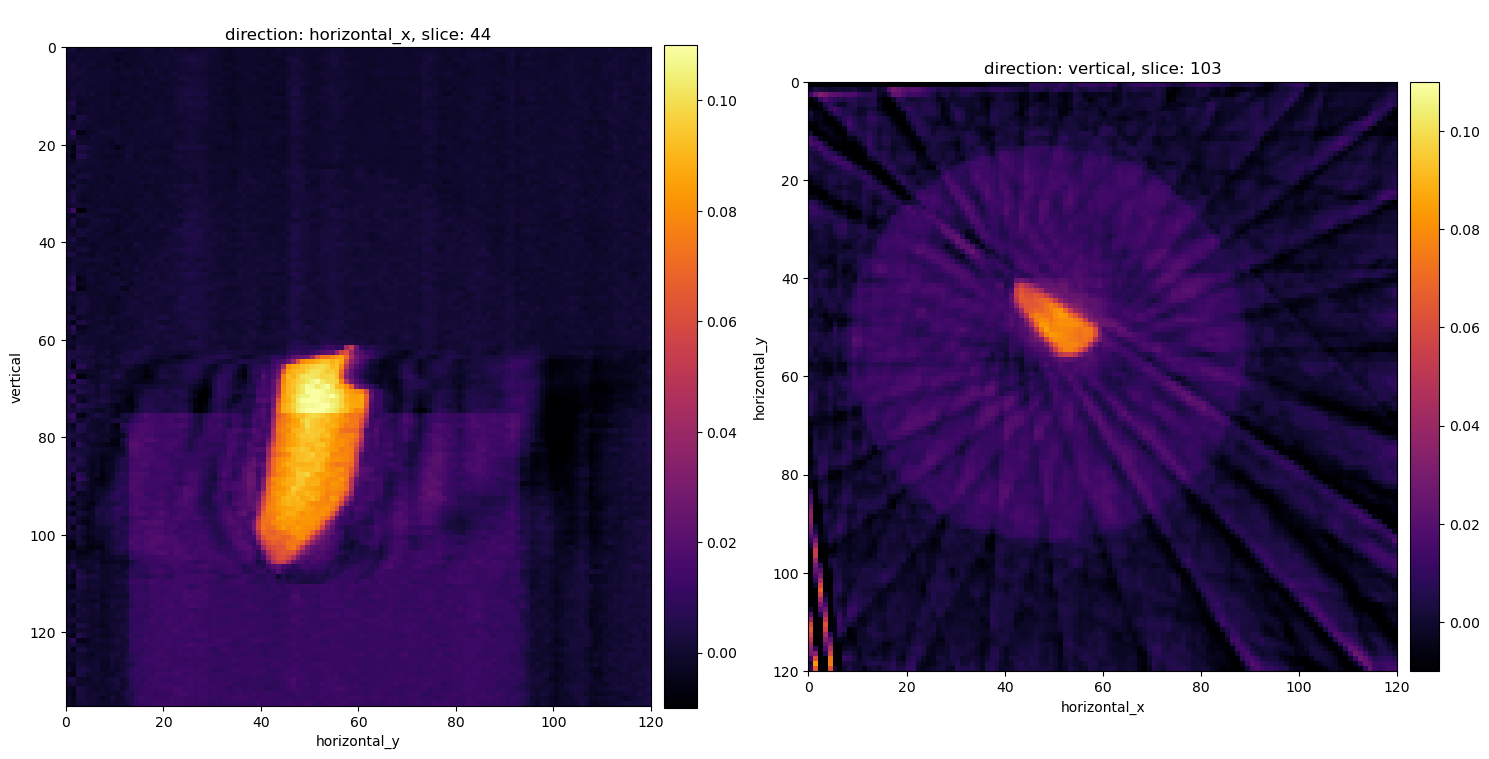

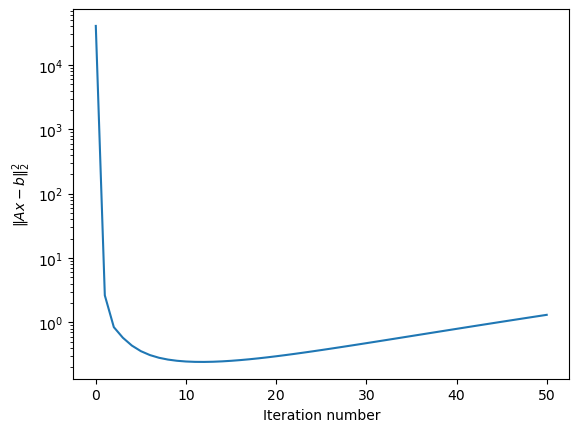

In [5]:
cil_sirt = SIRT(operator=A, data=data15, update_objective_interval=1)
cil_sirt.run(50)

show2D(cil_sirt.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
plt.figure()
plt.semilogy(cil_sirt.objective)
plt.ylabel('$\|Ax-b\|_2^2$')
plt.xlabel('Iteration number')
plt.show()

# Tigre- SIRT algorithm 

In [6]:
from cil.plugins.tigre import CIL2TIGREGeometry
import tigre.algorithms as algs

tigre_geom, tigre_angles = CIL2TIGREGeometry.getTIGREGeometry(
            ig, ag)
tigre_projections = b.as_array()

# The main difference between them is the update process.
#   SART: Updates the image projection by projection
#   SIRT: Updates the image using the whole set of projections at once
#   OS-SART: middle ground. Updates the image using a subset of the
#            projections
#
#  Of these algorithms, SART is generally the one reaching a better image
#  (less L2 error) for the same amount of iterations, and SIRT is the
#  worst (still relatively similar). However, SART needs increased
#  computational time per iteration, as it needs to update the image very often,
#  while SIRT only updates the emage ones for the whole sets of projections.
#  OS-SART lies in the middle, reaching similar convergence (L2 error per
#  iteration) than SART but with less computational time than SART.
#
## Usage, with optional parameters.
# In the three algorithms, there are 4 mandatory input arguments:
# Projections, geometry, angles and number of iterations.
#
#
# Optional arguments for all of them
# ==========================================================================
# 'lambda': hyperparameter. The update will be multiplied by this number
# every iteration, to make the steps bigger or smaller. Default: 1
#
lmbda = 1


# 'lambdared': reduction multiplier for the hyperparameter.
# lambda=lambda*lambdared every iterations, so the steps can be smaller
# the further the update. Default=0.99
lambdared = 0.999

# 'Init' : Initialization method. Possible options are
#          None (default). There will be no initialization method, just
#                 the algorithm
#
#          'FDK'  Initialize the image with the result of FDK algorithm
#
#          'multigrid' Initialize using the multigrid method. The image
#                      will be solved in a small scale, and the size of it
#                      will increase until the desired size is reached.
#
#          'image'     Initialzies with a user given image. Not recoomended
#                      unless you really know what you are doing.

initmode = None

# 'InitImg' : related to init. The image to use for initializing the
# algorithm.

# 'verbose': boolean to make the algorithm display (or not) running state.
#            default true.

verbose = True
# 'Quameasopts'  Asks the algorithm for a set of quality measurement
#                parameters. Input should contain a list of desired
#                quality measurement names. Example: ['CC','RMSE','MSSIM']
#                These will be computed in each iteration.
#                Note that this is the change in parameter value per iteration, not the quality of the result.
qualmeas = ["RMSE", "SSD"]

# SIRT and SART both have no extra input parameters.
# =========================================================================
imgSIRT, qualitySIRT = algs.sirt(
    tigre_projections,
    tigre_geom,
    tigre_angles,
    50,
    lmbda=lmbda,
    lmbda_red=lambdared,
    verbose=verbose,
    Quameasopts=qualmeas,
    computel2=True,
)
imgSART, qualitySART = algs.sart(
    tigre_projections,
    tigre_geom,
    tigre_angles,
    50,
    lmbda=lmbda,
    lmbda_red=lambdared,
    verbose=verbose,
    Quameasopts=qualmeas,
    computel2=True,
)

# OS-SART
# ========================================================================
# Additionally OS-SART includes a couple of other parameters, related to
# the subsets.
#
#   'blocksize':   Sets the projection block size used simultaneously. If
#                  BlockSize = 1 OS-SART becomes SART and if  BlockSize = size(angles,2)
#                  then OS-SART becomes SIRT. Default is 20.
blcks = 10
# 'OrderStrategy':  Chooses the subset ordering strategy. Options are
#                  'ordered' :uses them in the input order, but divided
#                  'random'  : orders them randomly
#                  'angularDistance': chooses the next subset with the
#                                     biggest angular distance with the
#                                     ones used.  (default)
order = "random"
imgOSSART, qualityOSSART = algs.ossart(
    tigre_projections,
    tigre_geom,
    tigre_angles,
    50,
    lmbda=lmbda,
    lmbda_red=lambdared,
    verbose=verbose,
    Quameasopts=qualmeas,
    blocksize=blcks,
    OrderStrategy=order,
    computel2=True,
)


SIRT algorithm in progress.
Estimated time until completion : 00:00:02
SART algorithm in progress.
Estimated time until completion : 00:00:11
OSSART algorithm in progress.
Estimated time until completion : 00:00:03


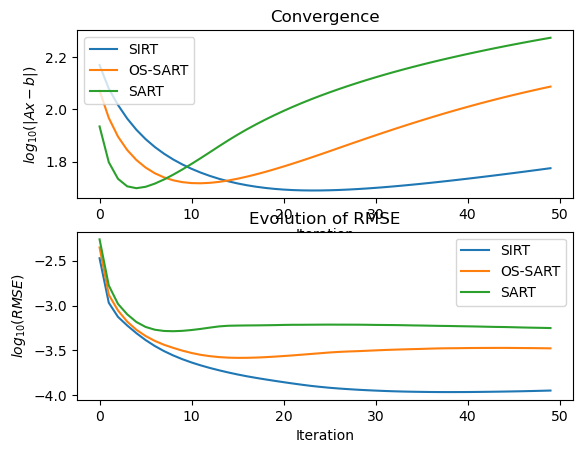

In [7]:
import numpy as np
plt.subplot(211)
plt.plot(np.log10(np.vstack((qualitySIRT[0, :], qualityOSSART[0, :], qualitySART[0, :]))).T)
plt.title("Convergence")
plt.xlabel("Iteration")
plt.ylabel("$ log_{10}(|Ax-b|) $")
plt.gca().legend(("SIRT", "OS-SART", "SART"))
plt.subplot(212)
plt.plot(np.log10(np.vstack((qualitySIRT[1, :], qualityOSSART[1, :], qualitySART[1, :]))).T)
plt.title("Evolution of RMSE")
plt.gca().legend(("SIRT", "OS-SART", "SART"))
plt.xlabel("Iteration")
plt.ylabel("$ log_{10}(RMSE) $")
plt.show()

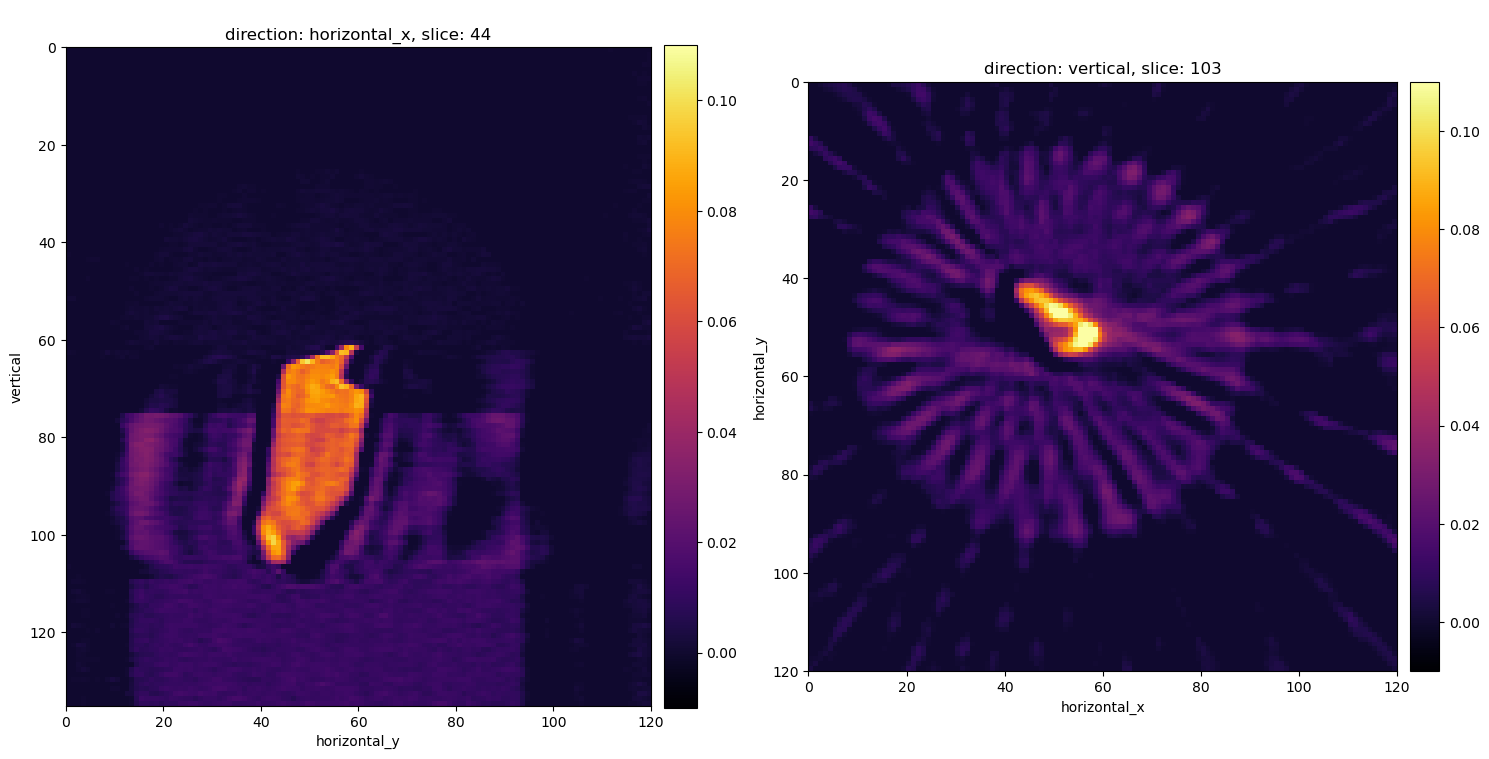

In [8]:
show2D(ImageData(imgSIRT, geometry=ig), 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


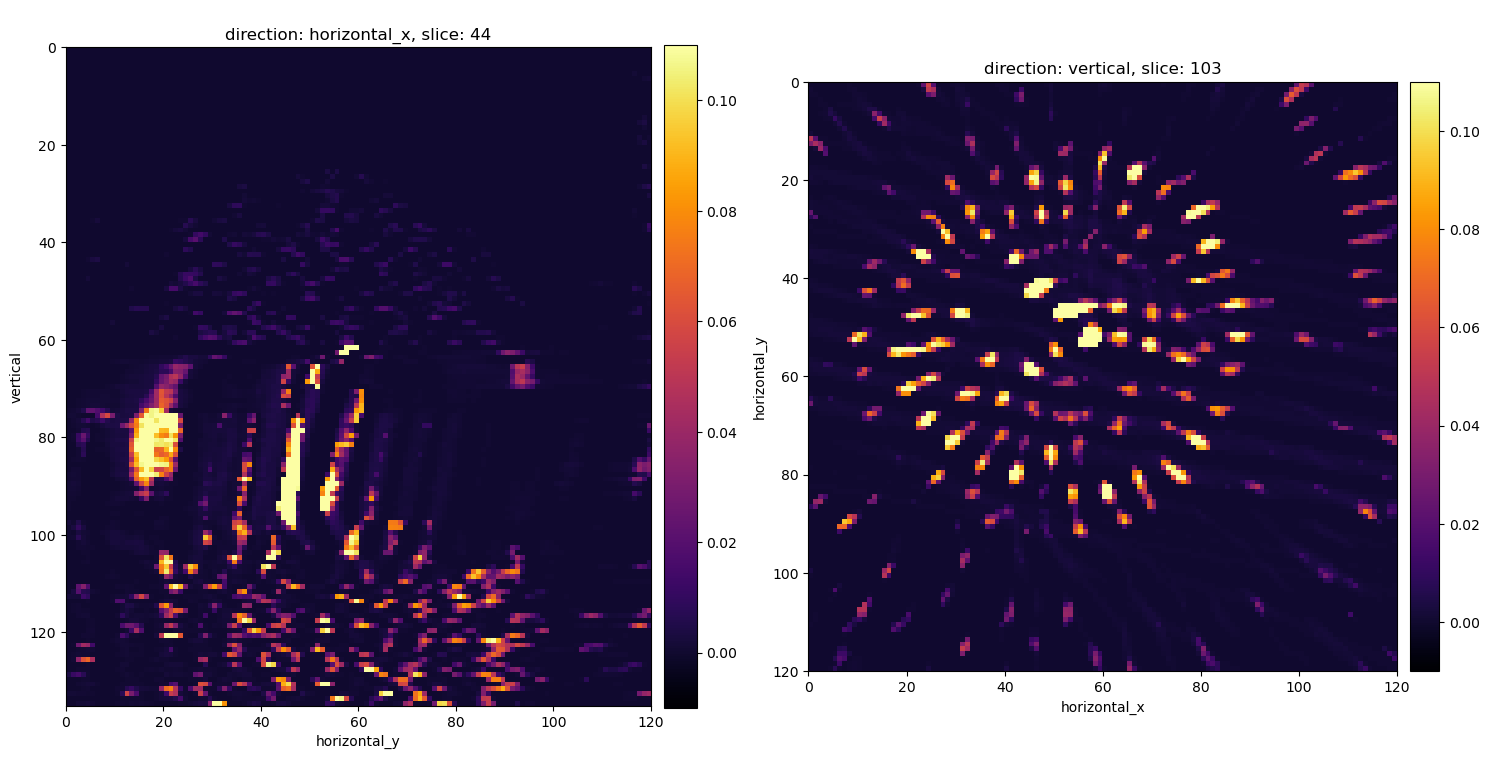

In [9]:
show2D(ImageData(imgSART, geometry=ig), 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


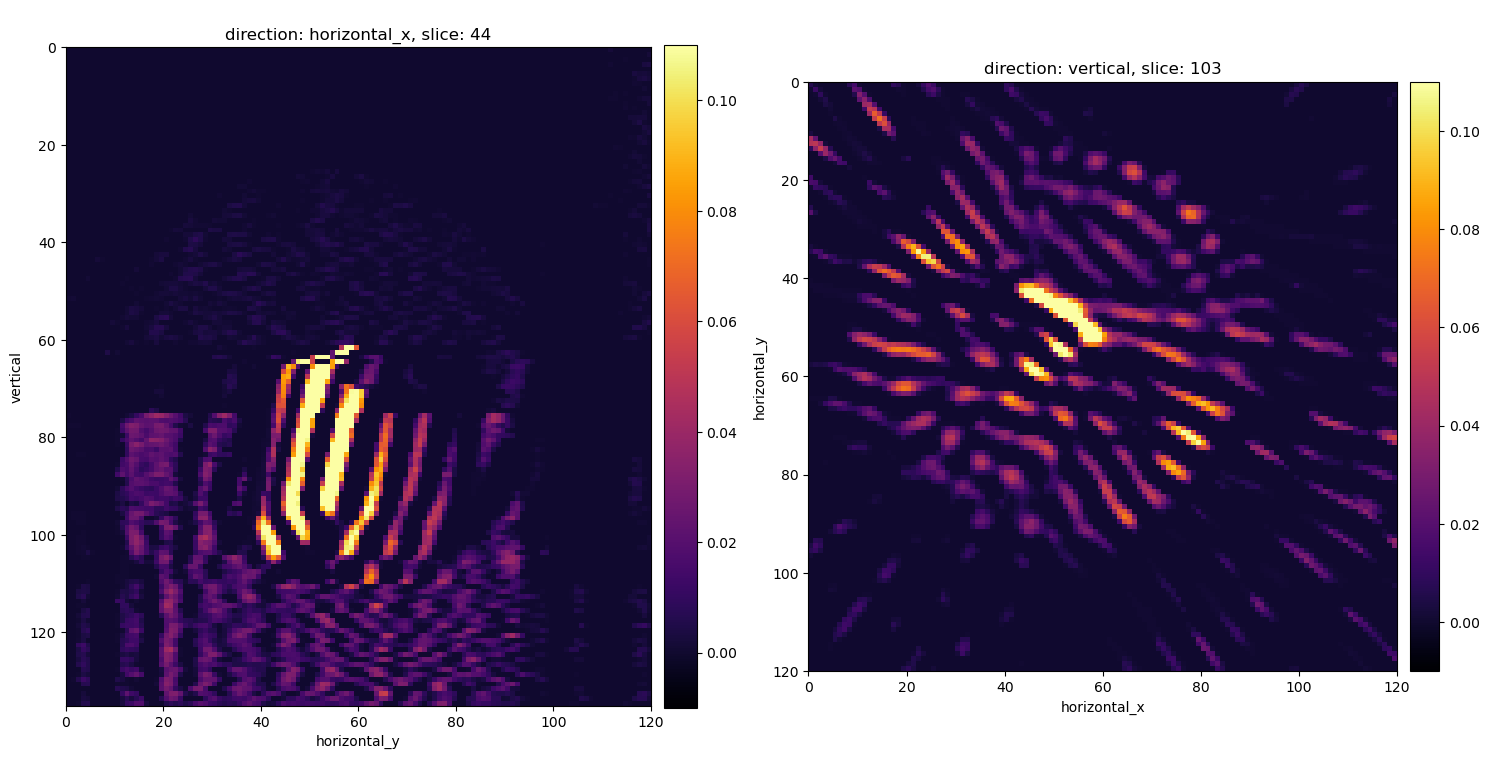

In [10]:
show2D(ImageData(imgOSSART, geometry=ig), 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

# CIL Wrapper 

In [11]:
from cil.plugins.tigre import ART, SIRT, SART, OSSART

In [12]:
#SIRT
#blocksize=tigre_angles.shape[0]

SIRT_algorithm_wrap = SIRT(initial=None, operator=A, data=data15)


SIRT_algorithm_wrap.run(50)

  0%|          | 0/50 [00:00<?, ?it/s]

<>:5: SyntaxWarning: invalid escape sequence '\|'
<>:5: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_972608/1106854596.py:5: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|Ax-b\|_2^2$')


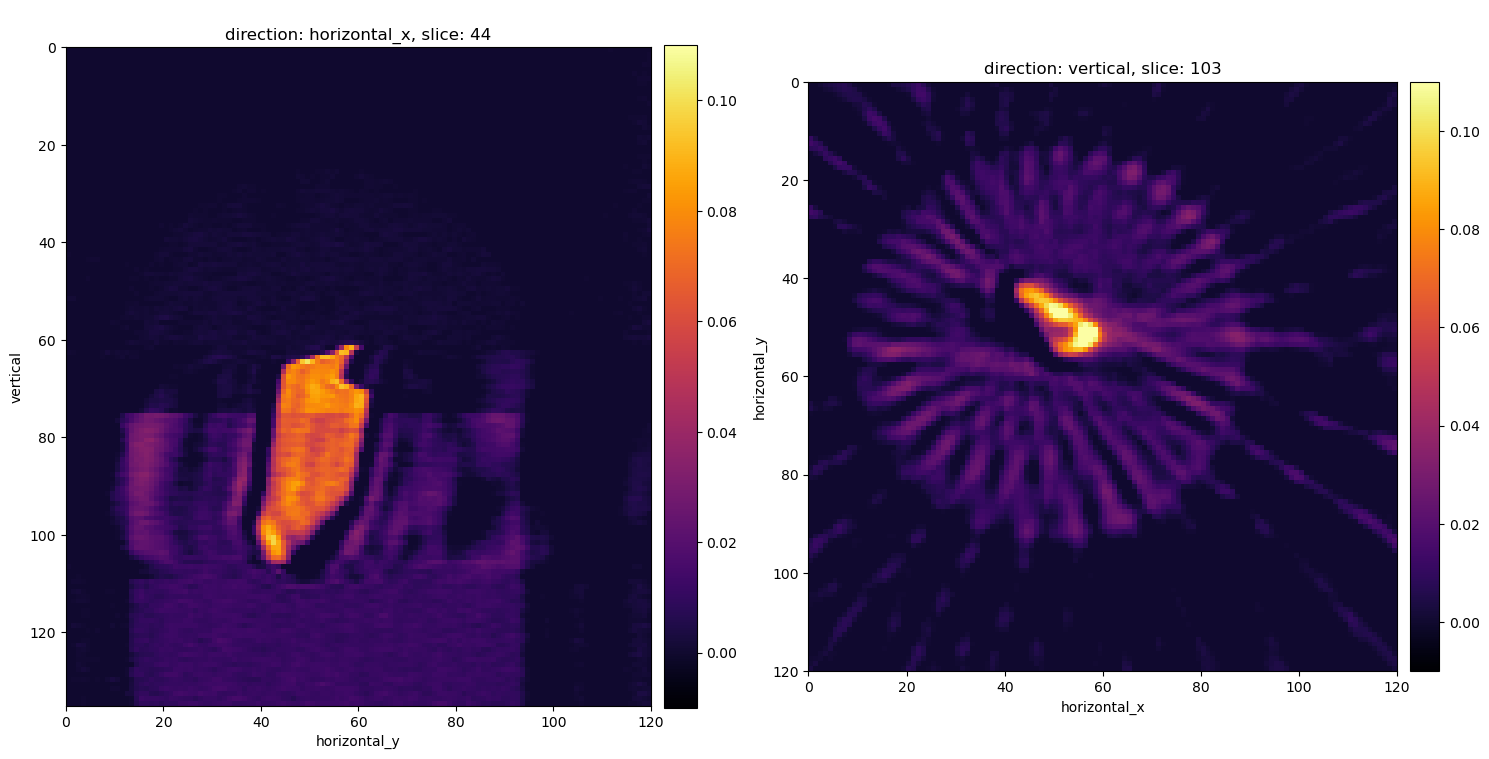

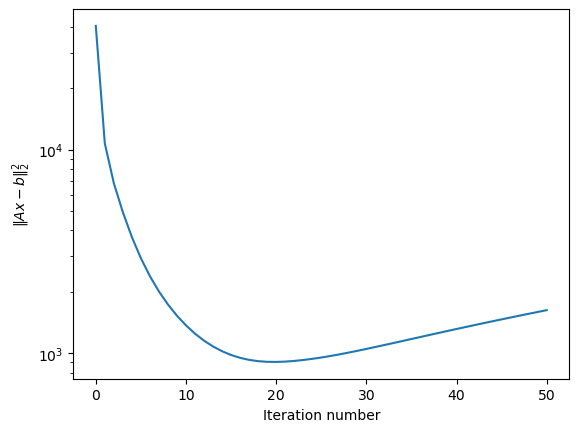

In [13]:
show2D(SIRT_algorithm_wrap.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
plt.figure()
plt.semilogy(SIRT_algorithm_wrap.objective)
plt.ylabel('$\|Ax-b\|_2^2$')
plt.xlabel('Iteration number')
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\|'
<>:13: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_972608/1508758544.py:13: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|Ax-b\|_2^2$')


  0%|          | 0/50 [00:00<?, ?it/s]

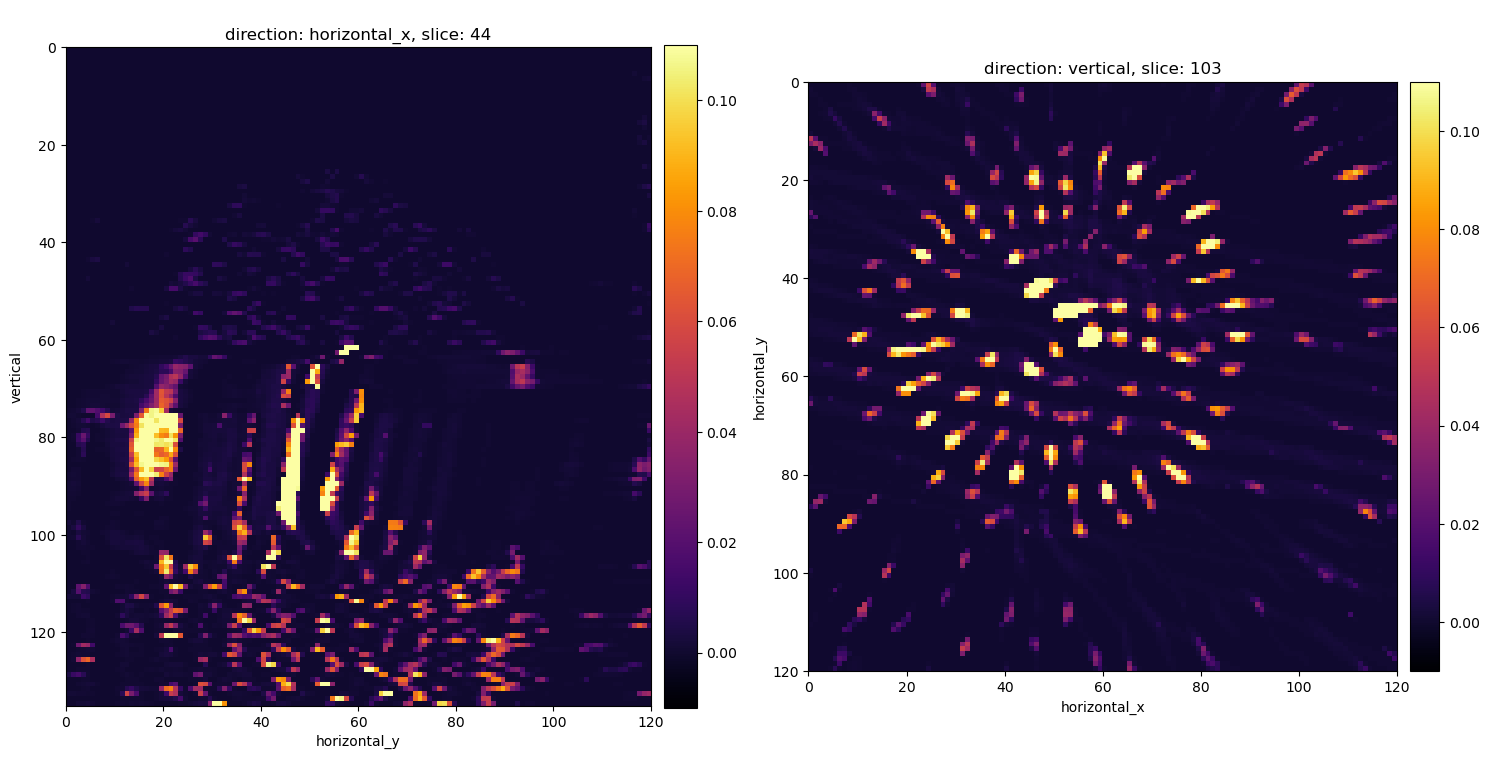

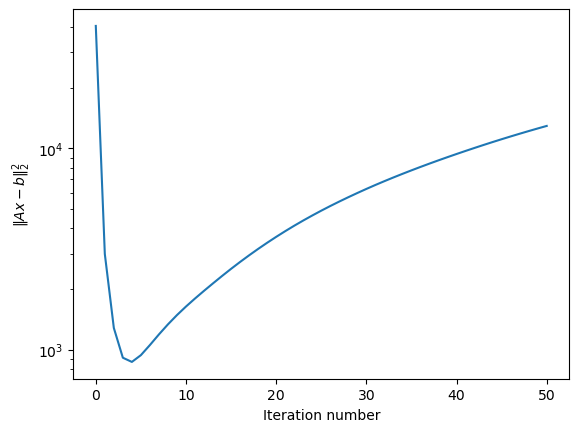

In [14]:
#SART
#blocksize=tigre_angles.shape[0]

SART_algorithm_wrap = SART(initial=None, operator=A, data=data15)


SART_algorithm_wrap.run(50)

show2D(SART_algorithm_wrap.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
plt.figure()
plt.semilogy(SART_algorithm_wrap.objective)
plt.ylabel('$\|Ax-b\|_2^2$')
plt.xlabel('Iteration number')
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\|'
<>:13: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_972608/316748769.py:13: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|Ax-b\|_2^2$')


  0%|          | 0/50 [00:00<?, ?it/s]

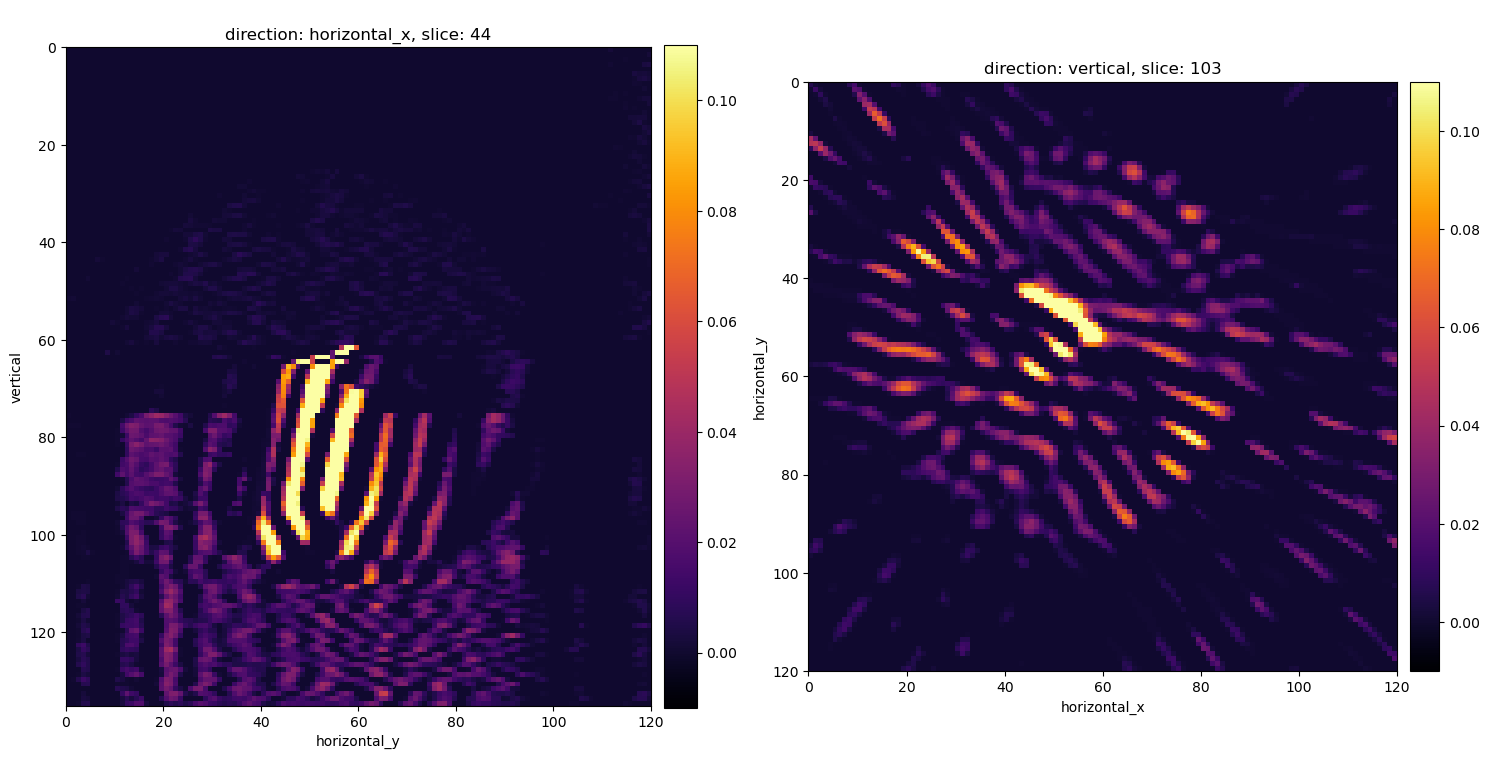

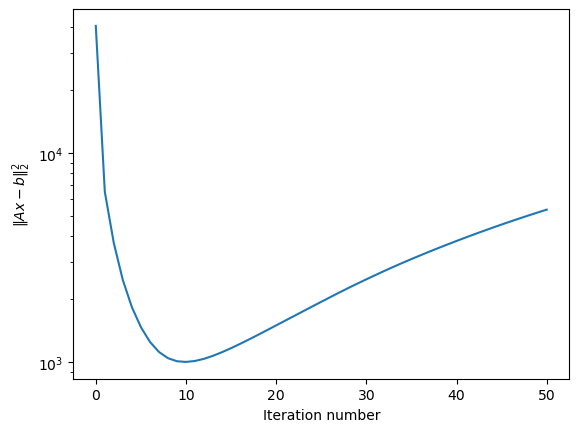

In [17]:
#OSSART
#blocksize=tigre_angles.shape[0]

OSSART_algorithm_wrap = OSSART(initial=None, operator=A, data=data15, blocksize=10)


OSSART_algorithm_wrap.run(50)

show2D(OSSART_algorithm_wrap.solution, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
plt.figure()
plt.semilogy(OSSART_algorithm_wrap.objective)
plt.ylabel('$\|Ax-b\|_2^2$')
plt.xlabel('Iteration number')
plt.show()